In [1]:
import os
import shutil
import pandas as pd
import geopandas as gpd
import rasterio
import s2cloudless
import numpy as np
import rasterio.warp
import matplotlib.pyplot as plt
import seaborn as sns

/Users/nikhilsrajan/NASA-Harvest/project/fetch_satdata/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('..')

In [3]:
import mysecrets
import fetch_from_cluster
import modify_images
import rsutils.utils
import create_stack

In [4]:
zip_filepath = fetch_from_cluster.download_file_from_cluster(
    sshcreds = mysecrets.SSH_UMD_SASIRAJANN,
    remotepath = '/gpfs/data1/cmongp2/sasirajann/data/misc/165bca4_s2l1c.zip',
    download_folderpath = '../data/cluster_files',
    overwrite = True,
)

In [5]:
stack_folderpath = '../data/165bca4_s2l1c_stack'

In [6]:
shutil.unpack_archive(zip_filepath, stack_folderpath)

In [7]:
bands, metadata = create_stack.load_stack(stack_folderpath)

In [8]:
bands.shape

(96, 490, 480, 13)

In [9]:
cloud_detector = s2cloudless.S2PixelCloudDetector(
    threshold=0.4, average_over=4, dilation_size=2, all_bands=True
)

In [10]:
# https://stackoverflow.com/questions/77783414/using-s2cloudless-to-generate-cloud-mask-using-sentinel-2-l1c-raw-data
# https://forum.step.esa.int/t/info-introduction-of-additional-radiometric-offset-in-pb04-00-products/35431
# https://sentiwiki.copernicus.eu/web/s2-processing
QUANTIFICATION_VALUE = 10000
RADIO_ADD_OFFSET = -1000

In [11]:
cmk = cloud_detector.get_cloud_probability_maps(data=(bands + RADIO_ADD_OFFSET) / QUANTIFICATION_VALUE)

In [12]:
int_cmk = (cmk * 10000).astype(int)

In [ ]:
int_cmk

(array([8850544.,  456548.,  278123.,   47756.,   22344.,   15730.,
          13960.,   15810.,   24203.,  768903.]),
 array([2.0000e+00, 1.0017e+03, 2.0014e+03, 3.0011e+03, 4.0008e+03,
        5.0005e+03, 6.0002e+03, 6.9999e+03, 7.9996e+03, 8.9993e+03,
        9.9990e+03]),
 <BarContainer object of 10 artists>)

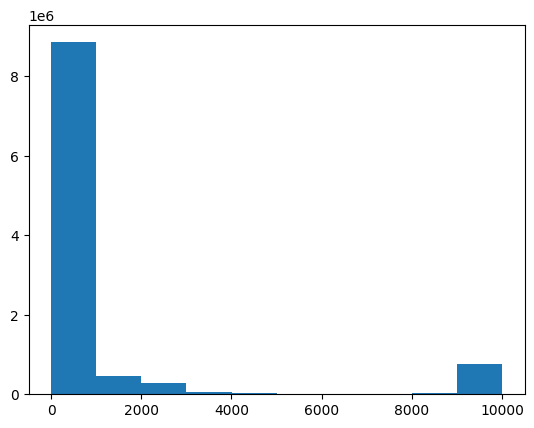

In [13]:
plt.hist(int_cmk[int_cmk > 1].flatten())

In [ ]:
cmk

In [19]:
(int_cmk > 4000).sum()

860950

In [ ]:
out_meta['dtype'] = cmk.dtype

In [ ]:
out_meta = rsutils.utils.driver_specific_meta_updates(meta=out_meta)
out_meta

In [ ]:
with rasterio.open(
    os.path.join(resampled_folderpath, 'CMK.jp2'),
    'w',
    **out_meta,
) as dst:
    dst.write(cmk)